## Imports


In [53]:
import json
import pandas as pd
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from PIL import Image,ImageFilter
from impact import Impact
plt.rcParams.update({'font.size': 14})#`ArithmeticError

In [51]:
%run -i Helper_Funcs.py

## Load Simulations

In [25]:
results=json.load(open('/sdf/data/ad/ard/u/cropp/Example_Data/scan_SOL11011_1000pC_64_image_compare_longer_123.json', 'r'))
sim_sol_conv=1.6 #Convert from PV value to T/m (simulation input)


## Load Data

In [26]:
pxcal=0.02061 #mm/px
df_read =pd.read_pickle('/sdf/data/ad/ard/u/cropp/Example_Data/20240128_F2_injector_expl_dataframe.pkl')
screen='PROF:IN10:241:Image:ArrayData'
df,idx=filter_df(df_read,screen)

imgArray=im_stack_from_df(df,"PROF:IN10:241:Image:ArrayData",'PROF:IN10:241:Image:ArraySize1_RBV','PROF:IN10:241:Image:ArraySize0_RBV',fliplr=1,rot=1)
#flip lr for data to match simulation (looking upstream vs downstream)
#rot for certain screens, now in PV

## Crop image & load into array

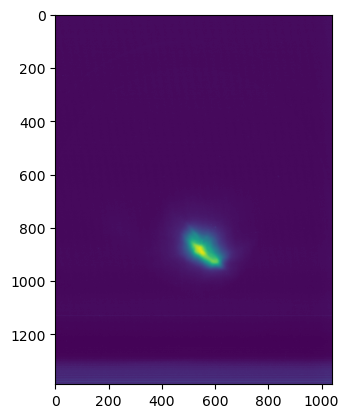

In [27]:
imgSum=np.sum(imgArray,0)
plt.imshow(imgSum)

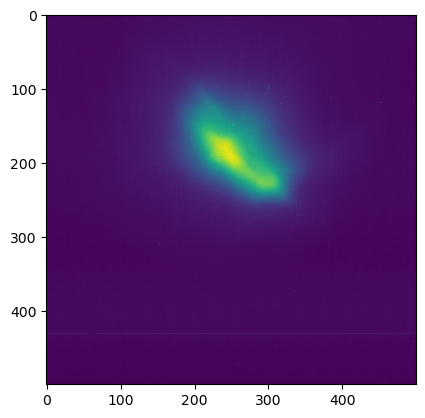

In [28]:
xStart=300
yStart=700
xEnd=800
yEnd=1200
imgCropp=imgSum[yStart:yEnd,xStart:xEnd]

plt.imshow(imgCropp)

In [29]:
imgArray=imgArray[:,yStart:yEnd,xStart:xEnd]

## Fit Data Gaussian

In [36]:
%%time
fits=imgArray_Fits(imgArray)

CPU times: user 16.7 s, sys: 72.6 ms, total: 16.7 s
Wall time: 16.8 s


## Load simulation particles & determine image sizes

In [39]:
%%time
P_list=[]
maxSz=0

for i in range(len(results['outputs'])):
# for i in range(3):
    afile=results['outputs'][i]['archive']
    I=Impact()
    I.load_archive(afile)
    P=I.particles['PR10241']
    P_list.append(P)
    xrms=np.std(P['x'])
    yrms=np.std(P['y'])
    bigSz=np.max([xrms,yrms])
    if bigSz>maxSz:
        maxSz=bigSz
    
print(maxSz)    

0.00184269107321304
CPU times: user 4.05 s, sys: 4.28 s, total: 8.33 s
Wall time: 8.53 s


## Make images from simulation data

In [43]:
%%time
pltRange=maxSz*6

for i in range(len(results['outputs'])):

    P=P_list[i]
    img=make_img_particles_hist(P['x'],P['y'],[[-1*pltRange,pltRange],[-1*pltRange,pltRange]])
    if i==0:
        imgArraySim=np.zeros([len(results['outputs']),np.shape(img)[0],np.shape(img)[1]])
    imgArraySim[i,:,:]=img    
simPxcal=(pltRange*2)*1000/np.shape(imgArraySim)[1]  

CPU times: user 4.15 s, sys: 53.7 ms, total: 4.2 s
Wall time: 4.21 s


## Simulation image fits

In [44]:
%%time
fitsSims=imgArray_Fits(imgArraySim)

CPU times: user 5.4 s, sys: 18 ms, total: 5.42 s
Wall time: 5.44 s


## Compare Data & Simulation Moments 
(With Same Calculation: Gaussian fitting from images)

(116,)


Text(0.5, 1.0, 'Partial Solenoid Scan at PR10241')

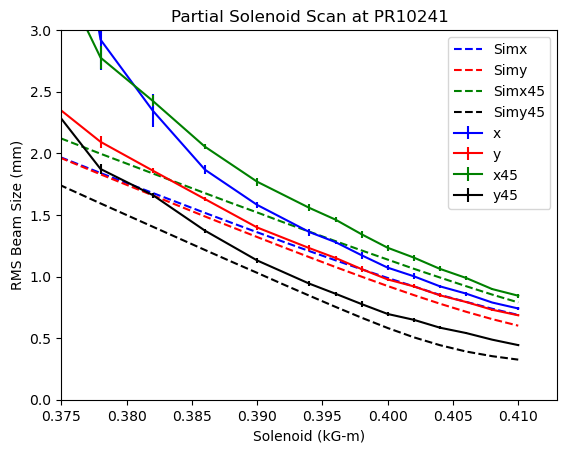

In [45]:
sols=(df['SOLN:IN10:121:BACT'].astype(float).round(decimals=int(5)))
unqSols=np.unique(sols)

simSols=np.array(results['x'])*sim_sol_conv*-1
um2mm=1000;

print(np.shape(sols))
labels=['x','y','x45','y45']
colors=['b','r','g','k']
for i in range(4):
    m,s=calc_img_stats(unqSols,sols,fits[i])
    idx=np.argsort(unqSols)
    plt.errorbar(unqSols[idx],m[idx]*pxcal,yerr=s[idx]*pxcal,fmt='-'+str(colors[i]),label=labels[i])
    
    idxSim=np.argsort(simSols)
    sigmas=np.array([x.Sigma for x in fitsSims[i]])
    plt.plot(simSols[idxSim],sigmas[idxSim]*simPxcal,'--'+str(colors[i]),label='Sim'+str(labels[i]))
                       

plt.legend()
ax=plt.gca()
ax.set_xlim([0.375,0.413])
ax.set_ylim([0,3])
plt.legend()
plt.xlabel('Solenoid (kG-m)')
plt.ylabel('RMS Beam Size (mm)')
plt.title('Partial Solenoid Scan at PR10241')

## Look at Images


No matching data
No matching data
No matching data
No matching data
No matching data
No matching data
No matching data


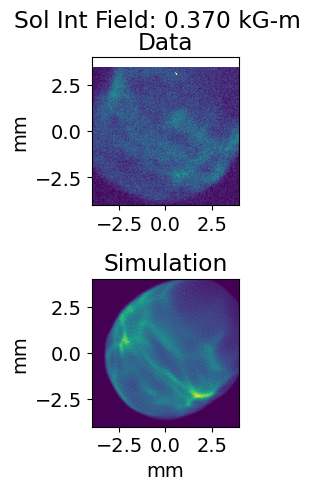

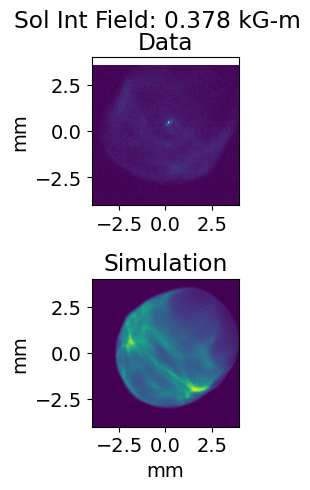

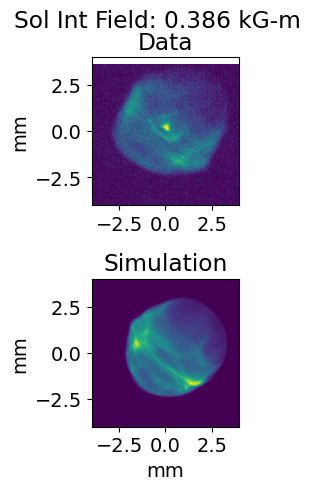

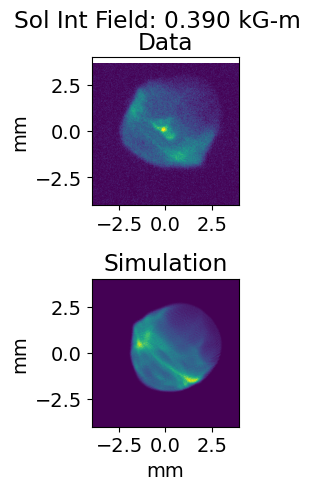

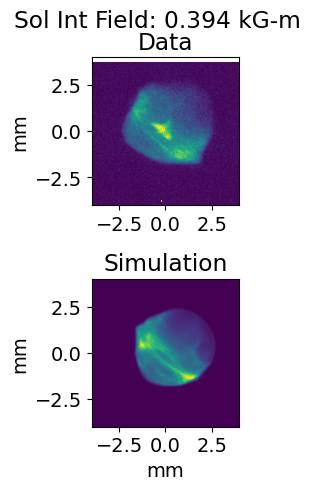

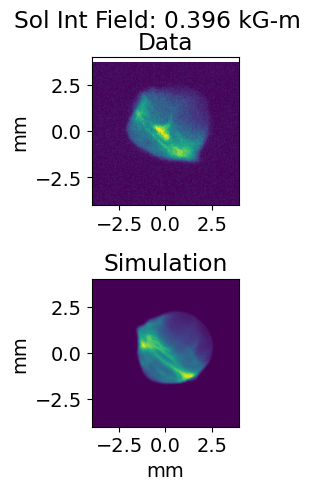

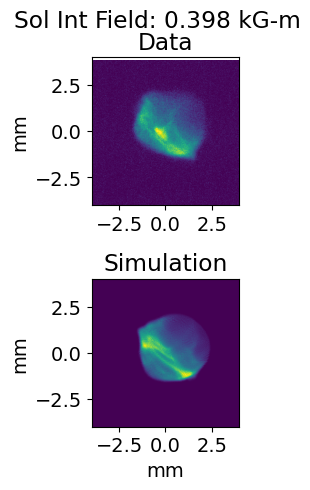

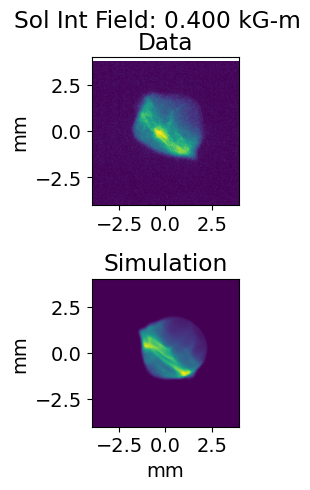

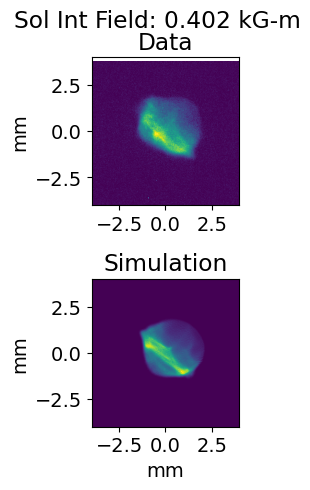

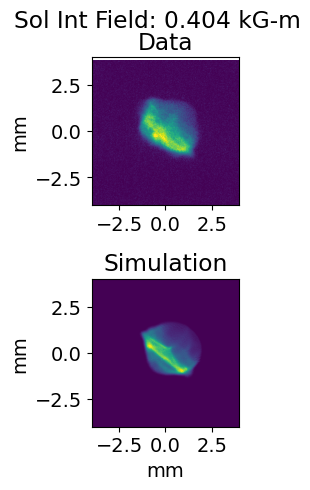

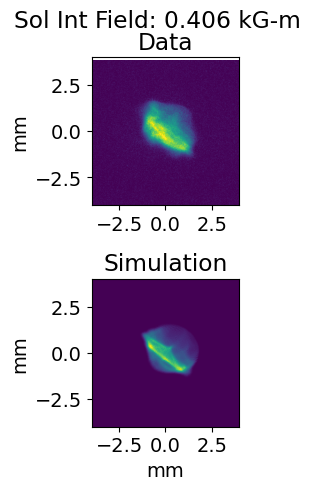

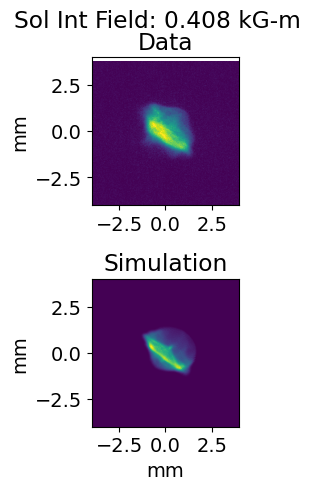

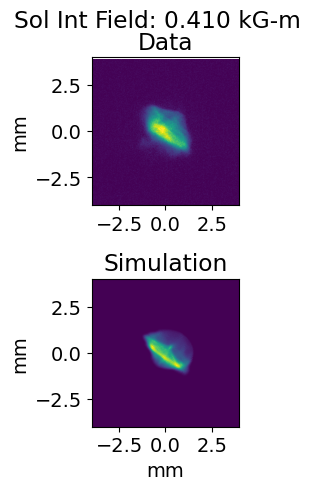

In [55]:
pltRange=4
left  = None # the left side of the subplots of the figure
right = None    # the right side of the subplots of the figure
bottom = None   # the bottom of the subplots of the figure
top = None     # the top of the subplots of the figure
wspace = None  # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots


for i in range(len(simSols)):

    try:
        idx=np.where(np.abs(simSols[i]-sols)<0.001)[0][0]
        f=plt.figure()
        f.tight_layout()
        plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    
        img=imgArray[idx,:,:]
        xCent=fits[0][idx].Center
        yCent=fits[1][idx].Center
        extent=Center_Image(img,pxcal,xCent,yCent)
        plt.subplot(2,1,1)
        plt.imshow(img,vmin=0,vmax=Max_Pixel(img),extent=extent)
        plt.xlim([-1*pltRange,pltRange])
        plt.ylim([-1*pltRange,pltRange])
        plt.ylabel('mm')
        
        imgSim=imgArraySim[i,:,:]
        extentSim=Center_Image(imgSim,simPxcal,fitsSims[0][i].Center,fitsSims[1][i].Center)
        plt.title('Data')
                        
        
        plt.subplot(2,1,2)
        plt.imshow(imgSim,extent=extentSim)
        plt.xlim([-1*pltRange,pltRange])
        plt.ylim([-1*pltRange,pltRange])
        plt.title('Simulation')
        plt.xlabel('mm')
        plt.ylabel('mm')
        titleStr='Sol Int Field: %5.3f kG-m' %(simSols[i])
        plt.suptitle(titleStr)
    except:
        print("No matching data")